<h1 align="center"><font size="5">Loan Default Prediction</font></h1>

In this notebook we use four different classification algorithms to predict if a customer will pay off their loan on time or not. This is a binary classification problem.   
We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression
- Random Froests
- Neural Networks

The end-to-end pipeline used in this project composed of these steps: 
1. Download data
2. Exploratory data analysis
3. Data pre-processing
5. Predictive modeling based on training data:
    - Tune model parameter based on mode accuracy using k-fold cross-validation
    - Build final model
6. Use models to predict the target variable in new data
7. Report model accuracies and suggest the best classifier


#### Import libraries:

In [1]:
# import itertools # Functions creating iterators for efficient looping
import numpy as np # Support for large multi-dimensional matrices and high-level mathematical functions
import matplotlib.pyplot as plt # Visualization
# from matplotlib.ticker import NullFormatter
import pandas as pd # Data manipulations and analysis of numerical tables and time-series
# import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing #provides common utility functions to change raw feature vectors into a representation that is more suitable for the downstream estimators.
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline 

#### Load data from a local Postgres server or directly from the web
The data is originally posted <a href="https://www.kaggle.com/zhijinzhai/loandata/activity">here </a>  on on Kaggle and includes customers who have paid off their loans or not. The data is splitte to two parts for training and test purposes. 
The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |



## 1. Download data

In [2]:
!wget -O loan_train.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
print('Download compelete!')
df = pd.read_csv('loan_train.csv')
print(df.shape)
df.head(3)


--2019-04-12 16:04:07--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
Resolving raw.githubusercontent.com... 151.101.248.133
Connecting to raw.githubusercontent.com|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23451 (23K) [text/plain]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.90K  --.-KB/s    in 0.01s   

2019-04-12 16:04:07 (1.80 MB/s) - 'loan_train.csv' saved [23451/23451]

Download compelete!
(346, 10)


,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male


## 2. Data preparation and exploratory analysis

In [3]:
# Droping unwanted Data from Dataframe
df = df.drop(['user_id','Un_named'],axis = 1)
df.head(2)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female


#### 2.1 Check features types

In [4]:
df.dtypes

loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Notice that "effective_date" and "due_date" are objects. We first convert their type to "date time".

##### Convert to date-time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df[['effective_date', 'due_date']].head(3)

,effective_date,due_date
0,2016-09-08,2016-10-07
1,2016-09-08,2016-10-07
2,2016-09-08,2016-09-22


#### Check for missing values

In [6]:
df.isnull().sum()

loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

#### 2.2 Basic exploratory analysis

In [7]:
def plot_adj(row, col, x_label, y_label, title):
    axis[row, col].set_axisbelow(True)
    axis[row, col].grid(which='minor', linestyle=':', color='black', alpha=0.2)
    axis[row, col].grid(which='major', linestyle='-', linewidth='0.5', color='red', alpha=0.2)
    axis[row, col].minorticks_on()
    axis[row, col].set_ylabel(y_label)
    axis[row, col].set_xlabel(x_label)
    axis[row, col].set_title(title, fontsize=16)

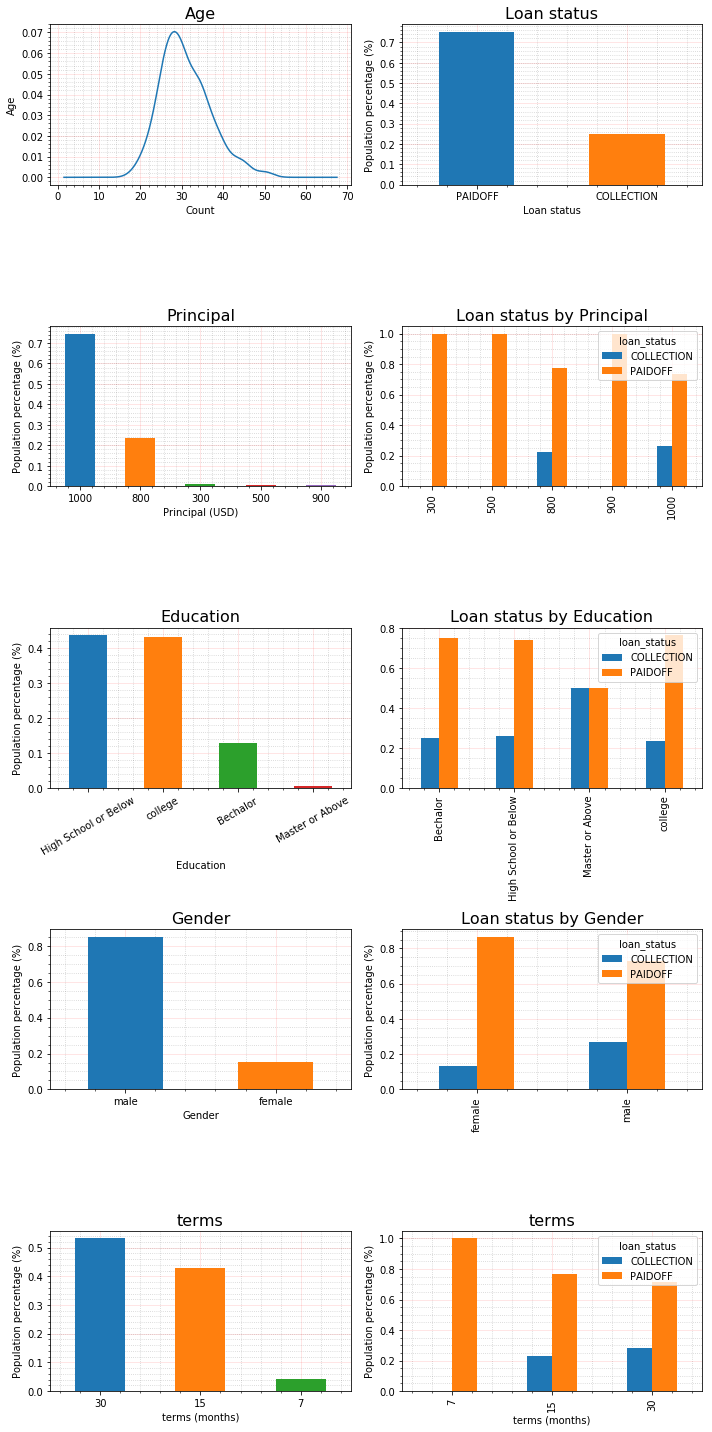

In [8]:
fig, axis = plt.subplots(5,2,figsize=(10,20), squeeze = 'False')
df['age'].plot(kind='kde', ax=axis[0, 0], rot='horizontal')
plot_adj(0, 0, 'Count', 'Age', 'Age')

(df['loan_status'].value_counts(normalize=True)
 .plot(kind='bar', ax=axis[0, 1], rot='horizontal'))
plot_adj(0, 1, 'Loan status', 'Population percentage (%)', 'Loan status')

(df['Principal'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[1, 0], rot='horizontal'))
plot_adj(1, 0, 'Principal (USD)', 'Population percentage (%)','Principal')

(df.groupby(['Principal'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[1, 1], rot='vertical'))
plot_adj(1, 1, '', 'Population percentage (%)','Loan status by Principal')



(df['education'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[2, 0], rot=30))
plot_adj(2, 0, 'Education', 'Population percentage (%)','Education')

(df.groupby(['education'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[2, 1], rot='vertical'))
plot_adj(2, 1, '', '','Loan status by Education')


(df['Gender'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[3, 0], rot='horizontal'))
plot_adj(3, 0, 'Gender', 'Population percentage (%)','Gender')

(df.groupby(['Gender'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[3, 1], rot='vertical'))
plot_adj(3, 1, '', 'Population percentage (%)', 'Loan status by Gender')




(df['terms'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[4, 0], rot='horizontal'))
plot_adj(4, 0, 'terms (months)', 'Population percentage (%)','terms')

(df.groupby(['terms'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[4, 1], rot='vertical'))
plot_adj(4, 1, 'terms (months)', 'Population percentage (%)','terms')


fig.tight_layout() # to improve the spacing between subplots

In [9]:
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [10]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

In [11]:
# import seaborn as sns

# bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
# g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
# g.map(plt.hist, 'Principal', bins=bins, ec="k")

# g.axes[1].legend()
# plt.show()

In [12]:
# bins = np.linspace(df.age.min(), df.age.max(), 10)
# g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
# g.map(plt.hist, 'age', bins=bins, ec="k")

# g.axes[1].legend()
# plt.show()

These graphs show that ignoring the 'gender' feature the on-time loan payment does not depend significantly on  'Principal' and 'Age' factors.

In [13]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, 
           vmin=None, vmax=None, alpha=None, linewidths=None, 
           verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c,
                       marker=marker, cmap=cmap, norm=norm, vmin=vmin,
                       vmax=vmax, alpha=alpha, linewidths=linewidths,
                       verts=verts, hold=hold, **kwargs)

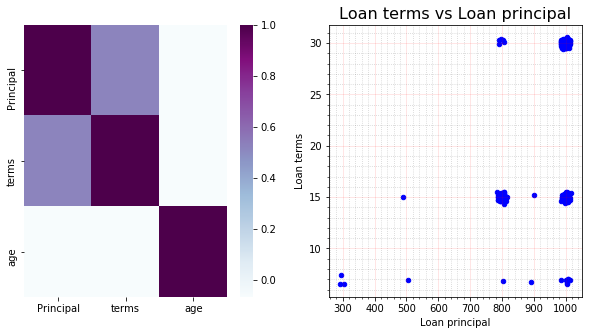

In [14]:
# Plotting heatmap of Data correlation
fig, axis = plt.subplots(1,2, squeeze = 'False', figsize = [10, 5])
sns.heatmap(data=df.corr(), cmap="BuPu", ax = axis[0])


jitter(x = df['Principal'], y = df['terms'])
# plt.axisbelow(True)
axis[1].grid(which='minor', linestyle=':', color='black', alpha=0.2)
axis[1].grid(which='major', linestyle='-', linewidth='0.5', color='red',
             alpha=0.2)
axis[1].minorticks_on()
axis[1].set_ylabel('Loan terms')
axis[1].set_xlabel('Loan principal')
axis[1].set_title('Loan terms vs Loan principal', fontsize=16)

plt.show()

There is a moderate correlation between loan terms and principal amount.

In [15]:
# Dividing age in three Diffrent Group.
def Age(age):
    if 18<=age<32:
        return 0
    elif 32<=age<46:
        return 1
    else:
        return 2
df['age_cat'] = df['age'].apply(Age)

In [16]:
df.head(3)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,age_cat
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,1
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,1
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,0


In [17]:
Principal_list = list(df['Principal'].unique())
terms_list = list(df['terms'].unique())
education_list = list(df['education'].unique())
Gender_list = list(df['Gender'].unique())
loan_status_list = list(df['loan_status'].unique())
# printing list of unique values
print('Principal:',Principal_list)
print('terms:',terms_list)
print('education:',education_list)
print('Gender:',Gender_list)

Principal: [1000, 800, 300, 900, 500]
terms: [30, 15, 7]
education: ['High School or Below', 'Bechalor', 'college', 'Master or Above']
Gender: ['male', 'female']


In [18]:
# Creating Dictionary of List to append values in Data frame

Principal_dict = {v:k for k,v in enumerate(Principal_list)}
terms_dict = {v:k for k,v in enumerate(terms_list)}
education_dict = {v:k for k,v in enumerate(education_list)}
Gender_dict = {v:k for k,v in enumerate(Gender_list)}
loan_status_dict = {v:k for k,v in enumerate(loan_status_list)}

In [19]:
# keep a (deep) copy of original dataframe
# orig_df = df.copy()
# orig_df.head(3)

In [20]:
# Appending Values to key using lambda function

df['Principal'] = df['Principal'].apply(lambda x:Principal_dict[x])
df['terms'] = df['terms'].apply(lambda x:terms_dict[x])
df['education'] = df['education'].apply(lambda x:education_dict[x])
df['Gender'] = df['Gender'].apply(lambda x:Gender_dict[x])
df['loan_status'] = df['loan_status'].apply(lambda x:loan_status_dict[x])

##### Create a new feature 
Look at the day of the week people get the loan: 

In [21]:
df['dayofweek'] = df['effective_date'].dt.dayofweek # Monday:0, Sunday:6
df.head(3)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,age_cat,dayofweek
0,0,0,0,2016-09-08,2016-10-07,45,0,0,1,3
1,0,0,0,2016-09-08,2016-10-07,33,1,1,1,3
2,0,0,1,2016-09-08,2016-09-22,27,2,0,0,3


In [22]:
df = df.drop(['due_date', 'effective_date'], axis = 1)
df.head()

,loan_status,Principal,terms,age,education,Gender,age_cat,dayofweek
0,0,0,0,45,0,0,1,3
1,0,0,0,33,1,1,1,3
2,0,0,1,27,2,0,0,3
3,0,0,0,28,2,1,0,4
4,0,0,0,29,2,0,0,4


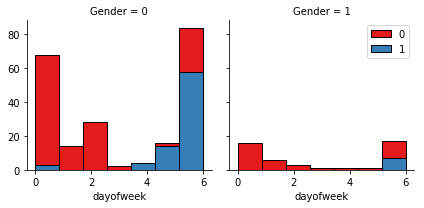

In [23]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use **Feature binarization** to set a threshold values less then day 4  for this new feature.

In [24]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(3)

,loan_status,Principal,terms,age,education,Gender,age_cat,dayofweek,weekend
0,0,0,0,45,0,0,1,3,0
1,0,0,0,33,1,1,1,3,0
2,0,0,1,27,2,0,0,3,0


In [25]:
df = df.drop(['dayofweek'], axis = 1)

##### One Hot Encoding  

Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data-Frame:

In [26]:
# Feature = df[['Principal','terms','age','Gender','weekend']]
# Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# # Drop rows with education feature of'Master or Above'
# # Feature.drop(['Master or Above'], axis = 1,inplace=True)
# Feature.head(3)


## 3. Create Feature and Target dataset

##### Features:

In [27]:
df.head(3)

,loan_status,Principal,terms,age,education,Gender,age_cat,weekend
0,0,0,0,45,0,0,1,0
1,0,0,0,33,1,1,1,0
2,0,0,1,27,2,0,0,0


In [28]:
Feature = df[['Principal','terms','age_cat','Gender', 'education','weekend']]
# Feature = df[['Principal','terms','Gender', 'education']]


# Drop rows with education feature of'Master or Above'
# Feature.drop(['Master or Above'], axis = 1,inplace=True)
X = df.drop(['loan_status', 'age', 'age_cat'], axis =1)
X[0:5]

,Principal,terms,education,Gender,weekend
0,0,0,0,0,0
1,0,0,1,1,0
2,0,1,2,0,0
3,0,0,2,1,1
4,0,0,2,0,1


##### Target variable:
The target attribute is a categorical variable with values: **[PAIDOFF**, **COLLECTIONS]**.  
That is why we will use classification models (and not the regression models) to predict the target variable.  
Since there are only two possible categories for target variable, the classification is a binary one.

In [29]:
y = df['loan_status']
# y[0:5]

##### Normalized Features

Data Standardization: give data zero mean and unit variance. 
Many machine learning algorithms work based on Eucledian or similar measures of distance and normalization of data is a rquired step before applying almost of the Machine learning algorithms.

In [113]:
X_raw = X.values # A copy of raw feature values 
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


array([[-0.50962675, -0.88434395, -1.06604119, -0.42056004, -1.20577805],
       [-0.50962675, -0.88434395, -0.00612667,  2.37778177, -1.20577805]])

In [31]:
# X_raw[0:2]

#### Select features with best ANOVA F-Values

In [32]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif


# # Create an SelectKBest object to select features with two best ANOVA F-Values
# fvalue_selector = SelectKBest(f_classif, k=3)

# # Apply the SelectKBest object to the features and target
# fvalue_selector.fit(X, y) # train the model
# X_kbest = fvalue_selector.transform(X) # transform data using the model

In [33]:
# X_kbest

In [34]:
# # Show results
# print('Original number of features:', X.shape[1])
# print('Reduced number of features:', X_kbest.shape[1])

Feature selection based on ANOVA F-Value: I examined this method by selecting the 3, 4, or 5 best features, but none of these improved the model accuracy. The results for the 5 best features are reported at the end of this notebook. 

#### 4. Predictive modeling based on loaded data: 

#### Parameter tuning with cross-validation  
Parameter tuning for each machine learning model: Find the model parameter value to build the model with best accuracy. The model accuracy is evaluated by performing **10-fold cross-validation**. The model accuracy is measured using:
- **F1-score**:weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: $$F1 = 2 * \frac{\text{precision} *\text{ recall}}{\text{precision} + \text{recall}}$$ Precision and recall are demonstrated as: <a href="https://en.wikipedia.org/wiki/Precision_and_recall"><img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" width="200" align="center"></a>
    - Precision: What proportion of positive identifications was actually correct? $$\text{Precision}= \frac{\text {TP}}{\text{TP+FP}}$$
    - Recall (sensitivity): What proportion of actual positives was identified correctly? $$\text{Recall}= \frac{\text {TP}}{\text{TP+FN}} $$
- **Jaccard similarity index**: The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union 

Function to plot model accuracy based on k-fold cross-validation:

In [35]:
def model_eval_plt(par, acu, model_name, model_par_name):
    # plot model accuracy for different values of k (k: number of neighbors)
    plt.figure(figsize=(10,5))
    plt.plot(par, acu, 'b', linewidth = 2)
    plt.ylabel('Accuracy', fontsize = 20)
    plt.xlabel('{}'.format(model_par_name),  fontsize = 20)
    plt.title('{} evaluation'.format(model_name), fontsize = 25)
    plt.yticks( fontsize = 15)
    plt.grid()
    plt.show()
    print('The highest accurcy is {:3.3} for {}= {}'.format(max(acu), model_par_name,
                                                                             par[np.argmax(acu)]))
    

In [36]:
# importing the model for prediction

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [37]:
# creating list of tuple with full and abreviated names, 
# name of the hyperparameter, values for the corresponding hyperparameter 
models = []
models.append(('KNN',KNeighborsClassifier(),
               'n_neighbors', np.linspace(1,20, 20)))
models.append(('DT',DecisionTreeClassifier(),
               'max_depth', np.linspace(1,10, 10)))
models.append(('RF',RandomForestClassifier(),
               'n_estimators', np.linspace(1,3, 3)))
# models.append(('LG',LogisticRegression(), 'C', np.linspace(0.001, 6, 200)))
models.append(('SVM',SVC(), 
               'kernel', ['linear', 'poly', 'rbf', 'sigmoid']))
# models.append(('DL',LogisticRegression()))

In [38]:
for name, model, param_name, param in models:
    print('--'*20)
    print(name, model, param_name, param[0:5], '\n\n')
    

----------------------------------------
KNN KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') n_neighbors [1. 2. 3. 4. 5.] 


----------------------------------------
DT DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') max_depth [1. 2. 3. 4. 5.] 


----------------------------------------
RF RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fr

In [39]:
from sklearn.model_selection import KFold
# imorting cross Validation for calcuting score
from sklearn.model_selection import cross_val_score


In [40]:
# for name, model, param_name, param in models:
#     print('Model: {}, parameters: {}'.format(model, param))
#     Jac_vals = []
#     F1_vals = []
#     acc_vals = []
    
#     for n in param:
#         # Build the model
#         thisModel = model
#         model_params = {param_name:n}
#         thisModel.set_params(**model_params)

        
# #         print(thisModel)
#         cross_val_score(thisModel, X, y, cv=10, scoring='accuracy')
# #         # perform a k-fold cross-validation to estimate the model accuracy
# #         folds = 10
# #         kfold = KFold(folds, True, 1)
# #         Jac_kfold_vals = []
# #         f1_kfold_vals = []
#         # enumerate splits
# #         for train_index, test_index in kfold.split(X):
# #             thisModel.fit(X[train_index], y[train_index])
# #             yhat = thisModel.predict(X[test_index])
# #             Jac_kfold_vals.append(jaccard_similarity_score(y[test_index], yhat))
# #             f1_kfold_vals[n2].append(f1_score(y[test_index], yhat,
# #                                      labels = ['PAIDOFF'], average='micro'))
        
# #     # compute the mean accuracy based on accuracy of k-folds 
# #     Jac_vals.append(Jac_kfold_vals.mean())
# #     F1_vals.append(f1_kfold_vals.mean())

# # print(acc_vals)
# #     # plot model evaluation and find the optimum parameter
# #     model_eval_plt(param, acc_vals, acc_vals, name, param_name)
        
    
# #     acc_of_model = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy')
   

#### 4.1 K-Nearest Neighbor classifier (KNN)



**4.1.1** Parameter tuning:  
The number of neighbors (K) in KNN should be selected by the user. We use cross-validation to decide on the best K value according to model's performance accuracy. 

In [41]:
# # # Replace the full features with selectrd fetures based on Anova analysis
# X = X_kbest

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, jaccard_similarity_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

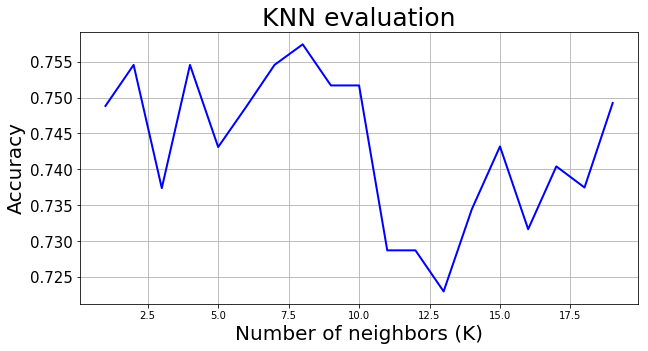

The highest accurcy is 0.757 for Number of neighbors (K)= 8


In [114]:
Ks = 20 # number of neighbors for KNN method
acu_vals = np.zeros((Ks-1))

for n in range(1, Ks):
    # Build the model
    knn = KNeighborsClassifier(n_neighbors=n)
    acu_vals[n-1] = cross_val_score(knn, 
                                    X, y, cv = 10, scoring = 'accuracy').mean()
# plot model evaluation and find the optimum parameter
model_par_name = 'Number of neighbors (K)'
model_name = 'KNN'
model_eval_plt(list(range(1, Ks)), acu_vals, model_name, model_par_name)

**5.2** Build the final KNN model  
Use the K-value that maximizes the model accuracy based on evaluation graph to build the final KNN model

In [115]:
k=14
knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X_train, y_train) 
knn.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='uniform')

As you can see, in addition to 'n_neighbors' there are other parameters that can be tuned in an attempt to achive higher accuracy, but we postpone is for now.

##### 4.2 Decision Tree

Decision trees are vary basic classifiers and have been around for a while and mainly replaced by other more sophisticate classifiers. Decision trees have been reborn recently because of their ability to be utilized in more modern classifiers like Random Forest or Gradient Boosting.  (ref:  <a href="https://www.udemy.com/machinelearning/">Machine Learning A-to-Z course on Udemy </a>)   
<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Decision%20Trees.png" width="800" align="left"></a>
<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Decision%20Trees_2.png" width="800" align="left"></a>


**4.2.1** Parameter tuning

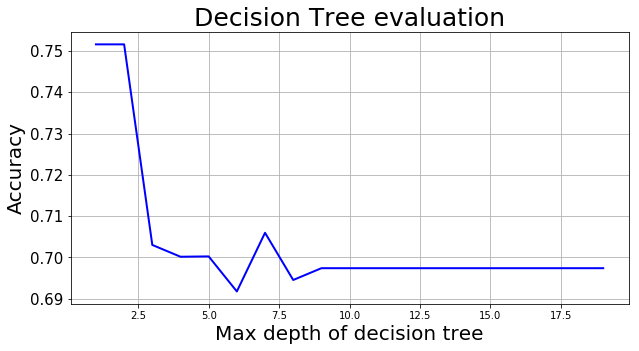

The highest accurcy is 0.752 for Max depth of decision tree= 1


In [116]:
from sklearn.tree import DecisionTreeClassifier
maxDepths = 20
acu_vals = np.zeros((maxDepths-1))
for n in range(1, maxDepths):
    # Build the model
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    acu_vals[n-1] = cross_val_score(loanTree, 
                                    X, y, cv = 10, scoring = 'accuracy').mean()

# plot model evaluation and find the optimum parameter
model_par_name = 'Max depth of decision tree'
model_name = 'Decision Tree'
model_eval_plt(list(range(1, maxDepths)), acu_vals, model_name, model_par_name)


Considering both accuracy metrics, 1 is a better choice for 'max_depth' parameter.

**5.2.2** Build the final decision tree model:

In [117]:
loanTree = DecisionTreeClassifier(criterion="entropy",
                                  max_depth = 1)
# loanTree.fit(X_train,y_train)
loanTree.fit(X.values,y)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

Aagain we see there are other model parameters that can be tuned in addition to max_depth. For now we keep the default values for other model parameters.

Visualize decision tree

In [47]:
# # Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

In [48]:
# from sklearn.externals.six import StringIO
# import pydotplus
# import matplotlib.image as mpimg
# from sklearn import tree
# %matplotlib inline 

In [49]:
# dot_data = StringIO()
# filename = "loantree.png"
# featureNames = Feature.columns
# targetNames = df["loan_status"].unique().tolist()
# out=tree.export_graphviz(loanTree,
#                          feature_names=featureNames,
#                          out_file=dot_data, 
#                          class_names= np.unique(targetNames), 
#                          filled=True,  
#                          special_characters=True,
#                          rotate=False)  
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png(filename)
# img = mpimg.imread(filename)
# plt.figure(figsize=(100, 200))
# plt.imshow(img,interpolation='nearest')

Accuracies:
1. Depth1: (138+122)/346 = 0.75
2. Depth2: (84+54+7+115)/346 = 0.75
3. Depth3: (44+10+97+18)/346 = 0.49
4. Depth4: (7+37+49+48+6+12)/346 = 0.46
5. Depth5: (3+34+6+45+38+10+6+3+9+3)/346 = 0.45
6. Depth6: (2+1+29+5+5+1+12+37+11+27+5+5+1+6+3+1)/346 = 0.44

#### 5.3 Support Vector Machine (SVM):

Intuition: The problem is to find the best decision boundry that help us to separate two classess. Then the model will be used to identify the class of new data:    

(ref:  <a href="https://www.udemy.com/machinelearning/">Machine Learning A-to-Z course on Udemy </a>)   
<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/SVM1.png" width="800" align="left"></a>


We are basically looking for a boundry with a maximum margin:  

<a href="https://www.udemy.com/machinelearning/"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/SVM2.png" width="800" align="left"></a>    


What is so special about SVMs?    
Instead of looking at the most standard or most frequent feature values for each class, the SVM looks at the least standard feature values for each class which are actually the support vectors. 

Which **kernel** results in highest accuracy?
Rebuild the model using 4 different kernels, compute the accuracy for each model, select the best kernel.  
Kernels to be tested: 

    1.Linear  
    2.Polynomial  
    3.Radial basis function (RBF)  
    4.Sigmoid  
    
Each of these functions has their own characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results.

**5.3.1** Parameter tuning:

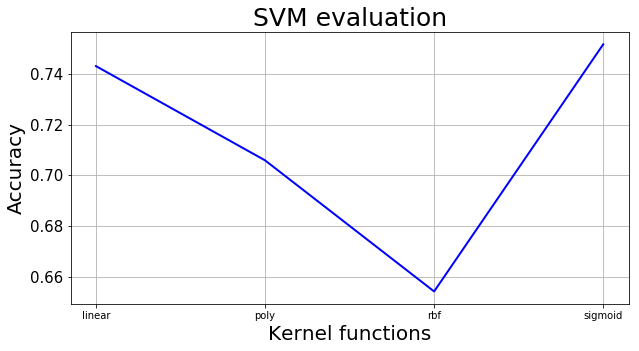

The highest accurcy is 0.752 for Kernel functions= sigmoid


In [118]:
from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
n=0
acu_vals = np.zeros(len(kernels))
for myKernel in kernels:
    # Build the model
    loanSVM = svm.SVC(C = 1, kernel=myKernel, gamma = 'auto')
    acu_vals[n-1] = cross_val_score(loanSVM, 
                                    X, y, cv = 10, scoring = 'accuracy').mean()
    n+=1

# plot model evaluation and find the optimum parameter
model_par_name = 'Kernel functions'
model_name = 'SVM'
model_eval_plt(kernels, acu_vals, model_name, model_par_name)

All kernels work with comparable accuracies, except rbf.

There are other parameters that can be tuned e.g. the degree of the polynomial function. This is beyond the scope of this work. 
The figure shows both polynomial (default degree of 3) and rbf result in same accuracy.

**5.3.2** Build final SVM classifier:

In [51]:
loanSVM = svm.SVC(C = 1, kernel='linear', gamma = 'auto')
loanSVM.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### 5.4 Logistic Regression

**Intuition:**. 
Logistic regression can be considered as the extension of linear regression to the cases when a categorical variable should be predicted.  
<a href="https://www.sciencedirect.com/topics/medicine-and-dentistry/logistic-regression-analysis"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Logistic_reg_2.png" width="300" align="left"></a>



<a href="https://towardsdatascience.com/how-are-logistic-regression-ordinary-least-squares-regression-related-1deab32d79f5"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/Resources/Algorithm_figs/Logistic_reg_3.png" width="300" align="left"></a>     


Logistic regression has a regularization parameter called C. Small values of C increase the regularization strength which will create simple models which underfit the data. Big values of C lower the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data. 
Plot accuracy curves based on different C values to find the best for this dataset.

**5.4.1** Parameter tuning

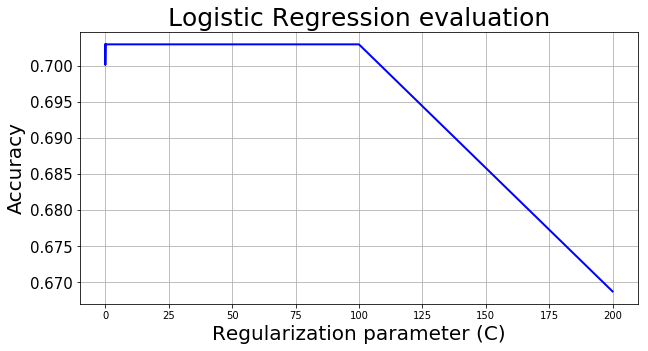

The highest accurcy is 0.703 for Regularization parameter (C)= 0.001


In [119]:
from sklearn.linear_model import LogisticRegression
Cvec = [0.001, 0.01, 0.1, 1, 10, 50, 80, 100, 200]
n=0
acu_vals = np.zeros(len(Cvec))
for myC in Cvec:
#     print(myC)
    # Build the model
    LR = LogisticRegression(C=myC, solver='liblinear') # liblinear is recommended for smal datasets
    acu_vals[n-1] = cross_val_score(LR, 
                                    X, y, cv = 10, scoring = 'accuracy').mean()
    n+=1    
# plot model evaluation and find the optimum parameter
model_par_name = 'Regularization parameter (C)'
model_name = 'Logistic Regression'
model_eval_plt(list(Cvec), acu_vals, model_name, model_par_name)

In [53]:
myC


200

**5.4.2** Build final Logistic Regression classifier.

In [120]:
LR = LogisticRegression(C=2.2, solver='liblinear')
# LR.fit(X_train,y_train)
LR.fit(X,y)

LogisticRegression(C=2.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### 5.5 Random Forest model  
Random forest model is a type of ensemble learning where a machine learning algorithm leverages many different other machine larning algorithms. Random forest method combines a lot of decision tree methods. 
Basically you first select the number of trees, then build each one of those decision trees based on a randomly selected subset of data. At the end when you have a new data point to predict, use each decision tree to predict the outcome for that new data point. The final result will be the category that received the highest vote from all trees.

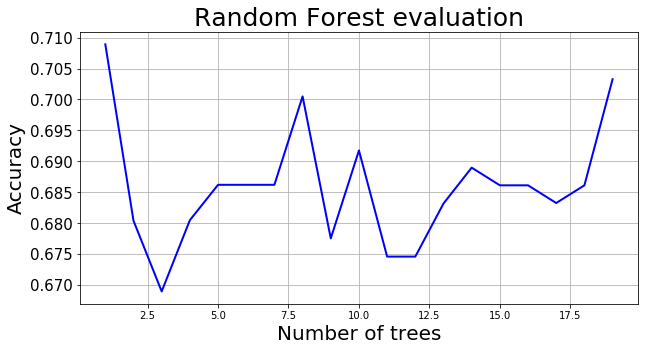

The highest accurcy is 0.709 for Number of trees= 1


In [122]:
from sklearn.ensemble import RandomForestClassifier
# RF = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
# RF.fit(X, y)

n_estimators_vec = range(1, 20)
n=0
acu_vals = np.zeros(len(n_estimators_vec))
for my_n_estimators in n_estimators_vec:
    # Build the model
    RF = RandomForestClassifier(n_estimators = my_n_estimators,
                                criterion = 'entropy', 
                               random_state = 0) 
    acu_vals[n-1] = cross_val_score(RF, 
                                    X, y, cv = 10, scoring = 'accuracy').mean()
    
    n+=1


    
# plot model evaluation and find the optimum parameter
model_par_name = 'Number of trees'
model_name = 'Random Forest'
model_eval_plt(list(n_estimators_vec), acu_vals, model_name, model_par_name)


#### Build the final Random Forest model:

In [56]:
RF = RandomForestClassifier(n_estimators = 8,
                                criterion = 'entropy', 
                               random_state = 0) 
RF.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### 5.5 Deep learning classifier

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=9, init='uniform', activation='sigmoid'))
model.add(Dense(12, init='uniform', activation='relu'))
model.add(Dense(12, init='uniform', activation='relu'))
model.add(Dense(12, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# convert target variable to a binary one

df_copy = df
df['loan_status_bin'] = df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1])
# df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)


In [ ]:
# Feature = df[['Principal','terms','age','Gender','weekend']]
# Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# X = Feature
y = df['loan_status_bin'].values


In [ ]:
model.fit(X, y, nb_epoch=300, batch_size=5, verbose=True)

## 6. Use models to predict the target variable in new data

### 6.1 Preprocessing of new datset:

**Download** and **load** the new dataset:

In [71]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
!wget -O loan_test.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
print('Download complete!')

--2019-04-12 16:14:27--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
Resolving raw.githubusercontent.com... 151.101.248.133
Connecting to raw.githubusercontent.com|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/plain]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-04-12 16:14:27 (17.5 MB/s) - 'loan_test.csv' saved [3642/3642]

Download complete!


In [72]:
test_df = pd.read_csv('loan_test.csv')
test_df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female


**Preprocess** new dataset  
Preprocess in the SAME way as training data.

In [73]:
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek # Monday:0, Sunday:6

test_df['age_cat'] = test_df['age'].apply(Age)




In [74]:
test_df.head(3)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,age_cat
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,2
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1


In [75]:
Principal_list = list(test_df['Principal'].unique())
terms_list = list(test_df['terms'].unique())
education_list = list(test_df['education'].unique())
Gender_list = list(test_df['Gender'].unique())
loan_status_list = list(test_df['loan_status'].unique())
# printing list of unique values
print('Principal:',Principal_list)
print('terms:',terms_list)
print('education:',education_list)
print('Gender:',Gender_list)

Principal: [1000, 300, 800, 700]
terms: [30, 7, 15]
education: ['Bechalor', 'Master or Above', 'High School or Below', 'college']
Gender: ['female', 'male']


In [76]:
# Creating Dictionary of List to append values in Data frame
Principal_dict = {v:k for k,v in enumerate(Principal_list)}
terms_dict = {v:k for k,v in enumerate(terms_list)}
education_dict = {v:k for k,v in enumerate(education_list)}
Gender_dict = {v:k for k,v in enumerate(Gender_list)}
loan_status_dict = {v:k for k,v in enumerate(loan_status_list)}

In [77]:
# Appending Values to key using lambda function
test_df['Principal'] = test_df['Principal'].apply(lambda x:Principal_dict[x])
test_df['terms'] = test_df['terms'].apply(lambda x:terms_dict[x])
test_df['education'] = test_df['education'].apply(lambda x:education_dict[x])
test_df['Gender'] = test_df['Gender'].apply(lambda x:Gender_dict[x])
test_df['loan_status'] = test_df['loan_status'].apply(lambda x:loan_status_dict[x])


In [78]:
test_df = test_df.drop(['due_date', 'effective_date'], axis = 1)

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df = test_df.drop(['dayofweek'], axis = 1)

test_df.head(3)

,loan_status,Principal,terms,age,education,Gender,age_cat,weekend
0,0,0,0,50,0,0,2,0
1,0,1,1,35,1,1,1,1
2,0,0,0,43,2,0,1,1


Extract **features** and **target** data from new dataset:

In [109]:
Features = test_df[['Principal','terms','Gender', 'education','weekend']]



In [80]:
Features = df_test[['Principal','terms','Gender', 'education','weekend']]
# Feature = df[['Principal','terms','Gender', 'education']]


# Drop rows with education feature of'Master or Above'
# Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_new = test_df.drop(['loan_status', 'age', 'age_cat'], axis =1)
X_new[0:5]

,Principal,terms,education,Gender,weekend
0,0,0,0,0,0
1,1,1,1,1,1
2,0,0,2,0,1
3,0,0,3,1,1
4,2,2,0,1,1


In [81]:
y_new = test_df['loan_status']
y_new[0:5]

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

**Normalize** feature data

In [ ]:
# X_new_raw = X_new.values # for decision tree and random forest
# X_new = preprocessing.StandardScaler().fit(X_new).transform(X_new)
# X_new[0:2]

In [ ]:
# # Feature selection on new data SAME as what we did on training data
# X_new = fvalue_selector.transform(X_new)

### 6.2 Predictive modeling on new dataset

In [90]:
# KNN
# Notice that we are now using the model we have built previously
yhat = knn.predict(X_new)
(print('Accuracy = {:3.3}'
       .format(accuracy_score(y_new, yhat)
    )))

Accuracy = 0.685


In [91]:
# !conda install -c anaconda eli5 -y

In [102]:
import eli5
from eli5.sklearn import PermutationImportance

In [112]:
temp = test_df[Features]
new_X2 = pd.DataFrame(data=X_new[0:,0:], 
          index=X_new[0:,0],  
          columns=temp.columns)

ValueError: Must pass DataFrame with boolean values only

In [103]:
perm = PermutationImportance(knn, random_state=1).fit(X_new, y_new)
eli5.show_weights(perm, feature_names = new_X2.columns.tolist())

NameError: name 'new_X2' is not defined

In [95]:
# Descision Tree
yhat = loanTree.predict(X_new)
(print('Accuracy = {:3.3}'
       .format(accuracy_score(y_new, yhat)
    )))

Accuracy = 0.741


In [96]:
# perm = PermutationImportance(loanTree, random_state=1).fit(X_new, y_new)
# eli5.show_weights(perm, feature_names = new_X2.columns.tolist())

In [97]:
# SVM
yhat = loanSVM.predict(X_new)
(print('Accuracy = {:3.3}'
       .format(accuracy_score(y_new, yhat)
    )))

Accuracy = 0.741


In [98]:
# perm = PermutationImportance(loanSVM, random_state=1).fit(X_new, y_new)
# eli5.show_weights(perm, feature_names = new_X2.columns.tolist())

In [100]:
# Logistic regression
yhat = LR.predict(X_new)
yhat_prob = LR.predict_proba(X_new) # for LogLoss score that works on the probability of model prediction
(print('Accuracy = {:3.3}'
       .format(accuracy_score(y_new, yhat)
    )))

Accuracy = 0.741


In [101]:
# Random Forest
yhat = RF.predict(X_new)
(print('Accuracy = {:3.3}'
       .format(accuracy_score(y_new, yhat)
    )))

Accuracy = 0.685


In [ ]:
# DL
test_df['loan_status_bin'] = test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1])

y_new_bin = test_df['loan_status_bin'].values


scores = model.evaluate(X_new, y_new_bin)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



# Report


Table summarizes performance of models in predicting the loan payment.


| Algorithm          | Jaccard |  F1 |Accuracy|
|--------------------|---------|-----|------|
| KNN                |   0.65| 0.78|   |
| Decision Tree      |      0.68|0.80|   |
| SVM                |      0.72|0.84|   |
| LogisticRegression |        0.74|  0.85|   |
| Random Forest      |  0.66|0.78|   |
|Neural Network|NA|NA|0.76|



- Without k-fold cross-validation, the accuracies were lower. 
- Using **Univariate Feature Selectin** based on the ANOVA F-value (with 5 best ANOVA F-values) did not improve the accuracies.



***Conclusion:***   
All five models perform similary, but Logistic regresssion and SVM show slightly higher accuracies when compared to other classifiers.


## Notes:
1. There is a [great kernel on Kaggel](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model/notebook?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019) that uses ML explainablity tools to identify the importance of each feature in predictiong the outcome. This kernel has used kaggle course on [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability). The course is focused on how extract human understandable insights from any Machine Learning model. I need to implement the explainability analysis on thie loan data analysis.
2. [This kaggle kernel](https://www.kaggle.com/akshaymewada7/ml-on-loandataset) works on the original data set that the data set in my notebook is using. The kaggle kernel has implemented multiple ML predictors in a very organized way (for loop) and has reported accuracies >90% which is much higher than accuracies I have reached. I had a quick look at it and found that the main difference is the in the way how the normalization is performed. I need to update and improve the current code according to this kernel.
3. When an scaled(normalized) dataset has been used for training, then the same normalization should be performed on the test data before using them for prediction. For example if z-score is used for normalization of test data, then the sacaling parameters (mean and standard deviation) should be saved and used for sacaling of the test data. (Make sure this important step is taken into consideration in this code). (ref: Andrew NG' Machine learning course).